# Multi-Template-Matching

This tutorial gives an overview of the different ways to use multiple template matching for object recognition.
More documentation is available in the [wiki](https://github.com/LauLauThom/MultiTemplateMatching/wiki) section of the repository.

## Citations
If you use this implementation for your research, please cite:

*Multi-Template Matching: a versatile tool for object-localization in microscopy images;*  
Laurent SV Thomas, Jochen Gehrig
bioRxiv 619338; doi: https://doi.org/10.1101/619338

## Let's code !

In [2]:
# 1st import the package and check its version
import MTM
print("MTM version: ", MTM.__version__)

from MTM import matchTemplates, drawBoxesOnRGB

import cv2
from skimage.data import coins
import matplotlib.pyplot as plt

C:\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


MTM version:  1.15.1


Let's open some image of coins from scikit-image, we will showcase the multi-template matching for the detection of the coin locations

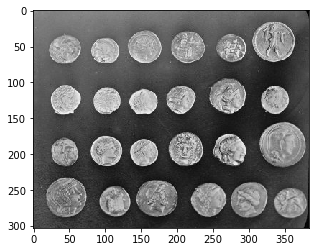

In [3]:
image = coins()
plt.imshow(image, cmap="gray")

We need some template image to search in the image.  
We can simply crop some coins from the image.  
__NB : templates are always rectangular (there are image matrices). And thus the predicted locations are always rectangular too !__

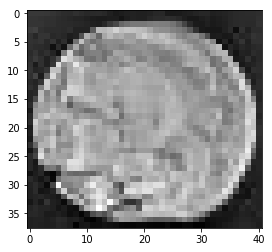

In [4]:
smallCoin = coins()[37:37+38, 80:80+41] 
plt.imshow(smallCoin, cmap="gray")

We will now use the `matchTemplates` function of the package MultiTemplateMatching.
The function has the following signature
`matchTemplates(listTemplates, image, method=cv2.TM_CCOEFF_NORMED, N_object=float("inf"), score_threshold=0.5, maxOverlap=0.25)`

- __listTemplates__   : list containing tuples like ("label", image) for each template that should be searched
- __image__           : this is the image in which the search is performed, in this case the image with the coins
- __method__          : one of OpenCV method for the computation of the correlation map (normalised difference, correlation...)
- __N_object__        : optionnal parameter, if set the function returns the N_object detections of highest score that do not overlap above the threshold
- __score_threshold__ : when performing multiple object detections, this is the minimal/maximal score for each detection when using respectively correlation/difference score
- __maxOverlap__      : Maximal ratio for the Intersection Over Union between overlapping detections. If above the threshold, the lower score bounding box is discarded.  

In [5]:
# 1st format the template into a list of tuple (label, templateImage)
listTemplate = [('small', smallCoin)]

# Then call the function matchTemplates (here a single template)
Hits = matchTemplates(listTemplate, image, score_threshold=0.5, method=cv2.TM_CCOEFF_NORMED, maxOverlap=0)

Here the coins are nicely separated so we do not expect any overlap between the predicted coins locations ie `maxOverlap=0`.  
For the score, we use a normalised cross-correlation `cv2.TM_CCOEFF_NORMED`, which is robust to illumination changes.  
Such score ranges from 0 to 1 and a good score is close to 1. `score_threshold=0.5` is thus usually a safe value.

Let's have a look at `Hits`...

In [6]:
print("Found {} hits".format( len(Hits.index) ) )
print(Hits)

Found 18 hits
                  BBox     Score TemplateName
0     [80, 37, 41, 38]  1.000000        small
1   [133, 108, 41, 38]  0.860809        small
2   [134, 178, 41, 38]  0.816142        small
3    [82, 106, 41, 38]  0.800473        small
4   [316, 105, 41, 38]  0.747887        small
5    [23, 178, 41, 38]  0.742243        small
6   [185, 103, 41, 38]  0.685315        small
7    [257, 34, 41, 38]  0.657859        small
8    [26, 103, 41, 38]  0.617952        small
9     [22, 37, 41, 38]  0.606692        small
10  [335, 247, 41, 38]  0.585767        small
11  [227, 239, 41, 38]  0.578679        small
12   [95, 244, 41, 38]  0.576981        small
13  [286, 237, 41, 38]  0.543841        small
14  [251, 106, 41, 38]  0.525461        small
15  [157, 234, 41, 38]  0.524984        small
16   [134, 37, 41, 38]  0.511432        small
17   [196, 27, 41, 38]  0.506829        small


As you can see, `Hits` is a table (pandas DataFrame) with one row per detection with:
- the name of the template that yield the match
- the coordinates of the bounding box (x, y, width, height)
- the score for that detection  

The first hit in the lsit has a score of 1 and is the coin that is used as template.

We can then represent the detections as bounding boxes overlaid on the image, with a tag for the label.

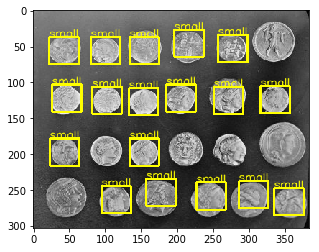

In [7]:
Overlay = drawBoxesOnRGB(image, Hits, showLabel=True)
plt.imshow(Overlay)

This is pretty good already but we dont catch some of the small coins.  
Let's reduce the score threshold to be more permissive e.g. `score_threshold = 0.4`

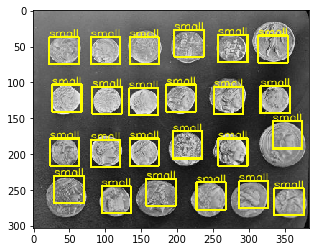

In [8]:
Hits = matchTemplates(listTemplate, image, score_threshold=0.4, method=cv2.TM_CCOEFF_NORMED, maxOverlap=0)
Overlay = drawBoxesOnRGB(image, Hits, showLabel=True)
plt.imshow(Overlay)

This is it !  
What if now we would like to do better and somehow differentiate between small and large coins...  
The function matchTemplates allow to use several templates, and yields the best detections for each location in the image.  
Let's crop one of the big coin to use as a second template.

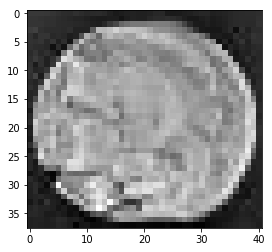

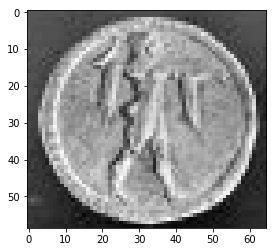

In [9]:
largeCoin = coins()[14:14+59,302:302+65]
plt.figure(0)
plt.imshow(smallCoin, cmap="gray")
plt.figure(1)
plt.imshow(largeCoin, cmap="gray")

Again we pack the templates in a list of tuples in the form `(label, template)`.    
Before calling the function `matchTemplates` and displaying the result.

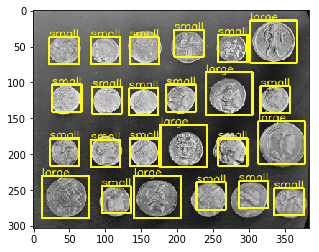

In [10]:
listTemplate = [("small", smallCoin), ("large", largeCoin)]
Hits = matchTemplates(listTemplate, image, score_threshold=0.4, method=cv2.TM_CCOEFF_NORMED, maxOverlap=0)
Overlay = drawBoxesOnRGB(image, Hits, showLabel=True)
plt.imshow(Overlay)

Et voila !  
Using several templates can be used to increase the chance to catch your object if it appears with different perspectives, or to perform classification of the detections using different templates as "classes".  
However, the more templates the longer the computation time.